In [2]:
# Install and import python_whois and tldextract
!pip install python-whois tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 9.6 MB/s eta 0:00:00


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse, parse_qs
import ipaddress
import tldextract
import re

In [6]:
# Load the dataset
df = pd.read_csv('/content/PhiUSIIL_Phishing_URL_Dataset.csv')

In [7]:
# Display initial data overview
print("Dataset Head:")
display(df.head())

Dataset Head:


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [8]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13 

In [9]:
print(f"\nDataset Shape: {df.shape}")


Dataset Shape: (235795, 56)


In [10]:
# Define URL processing functions
def url_structure(url):
    parsed_url = urlparse(url)
    if re.match(r"([a-zA-Z0-9\-]+\.)+[a-zA-Z]{2,}|(\d{1,3}\.){3}\d{1,3}", parsed_url.netloc):
        return "Valid"
    else:
        return "Suspicious"

def domain_name(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

def extract_subdomains(url):
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split(".")
    if len(domain_parts) > 2:
        return domain_parts[:-2]  # Exclude top-level and second-level domains
    return "No subdomains"

def preprocess_domain(domain):
    domain = domain.lower()
    try:
        domain = idna.decode(domain)  # Handle IDNs
    except idna.IDNAError:
        pass
    domain_parts = domain.split(".")
    return {
        "subdomains": domain_parts[:-2],
        "sld": domain_parts[-2],
        "tld": domain_parts[-1]
    }

def has_url_parameters(url):
    parsed_url = urlparse(url)
    return bool(parsed_url.query)

In [11]:
# Feature engineering
df['url_structure'] = df['URL'].apply(url_structure)
df['sld'] = df['URL'].apply(lambda url: preprocess_domain(domain_name(url))['sld'])
df['url_parameters'] = df['URL'].apply(has_url_parameters)

NameError: name 'idna' is not defined

In [ ]:
print("\nUpdated Dataset Head with New Features:")
display(df.head())

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

In [12]:
# Separate numerical and categorical dataframes
numeric_df = df.select_dtypes(include=np.number)
categorical_df = df.select_dtypes(exclude=np.number)

In [13]:
# Drop unnecessary columns from categorical dataframe
columns_to_drop = ['FILENAME', 'URL', 'Domain', 'Title']
categorical_df = categorical_df.drop(columns=columns_to_drop, errors='ignore')

In [14]:
print(f"\nNumerical DataFrame Shape: {numeric_df.shape}")
print(f"Categorical DataFrame Shape: {categorical_df.shape}")


Numerical DataFrame Shape: (235795, 51)
Categorical DataFrame Shape: (235795, 2)


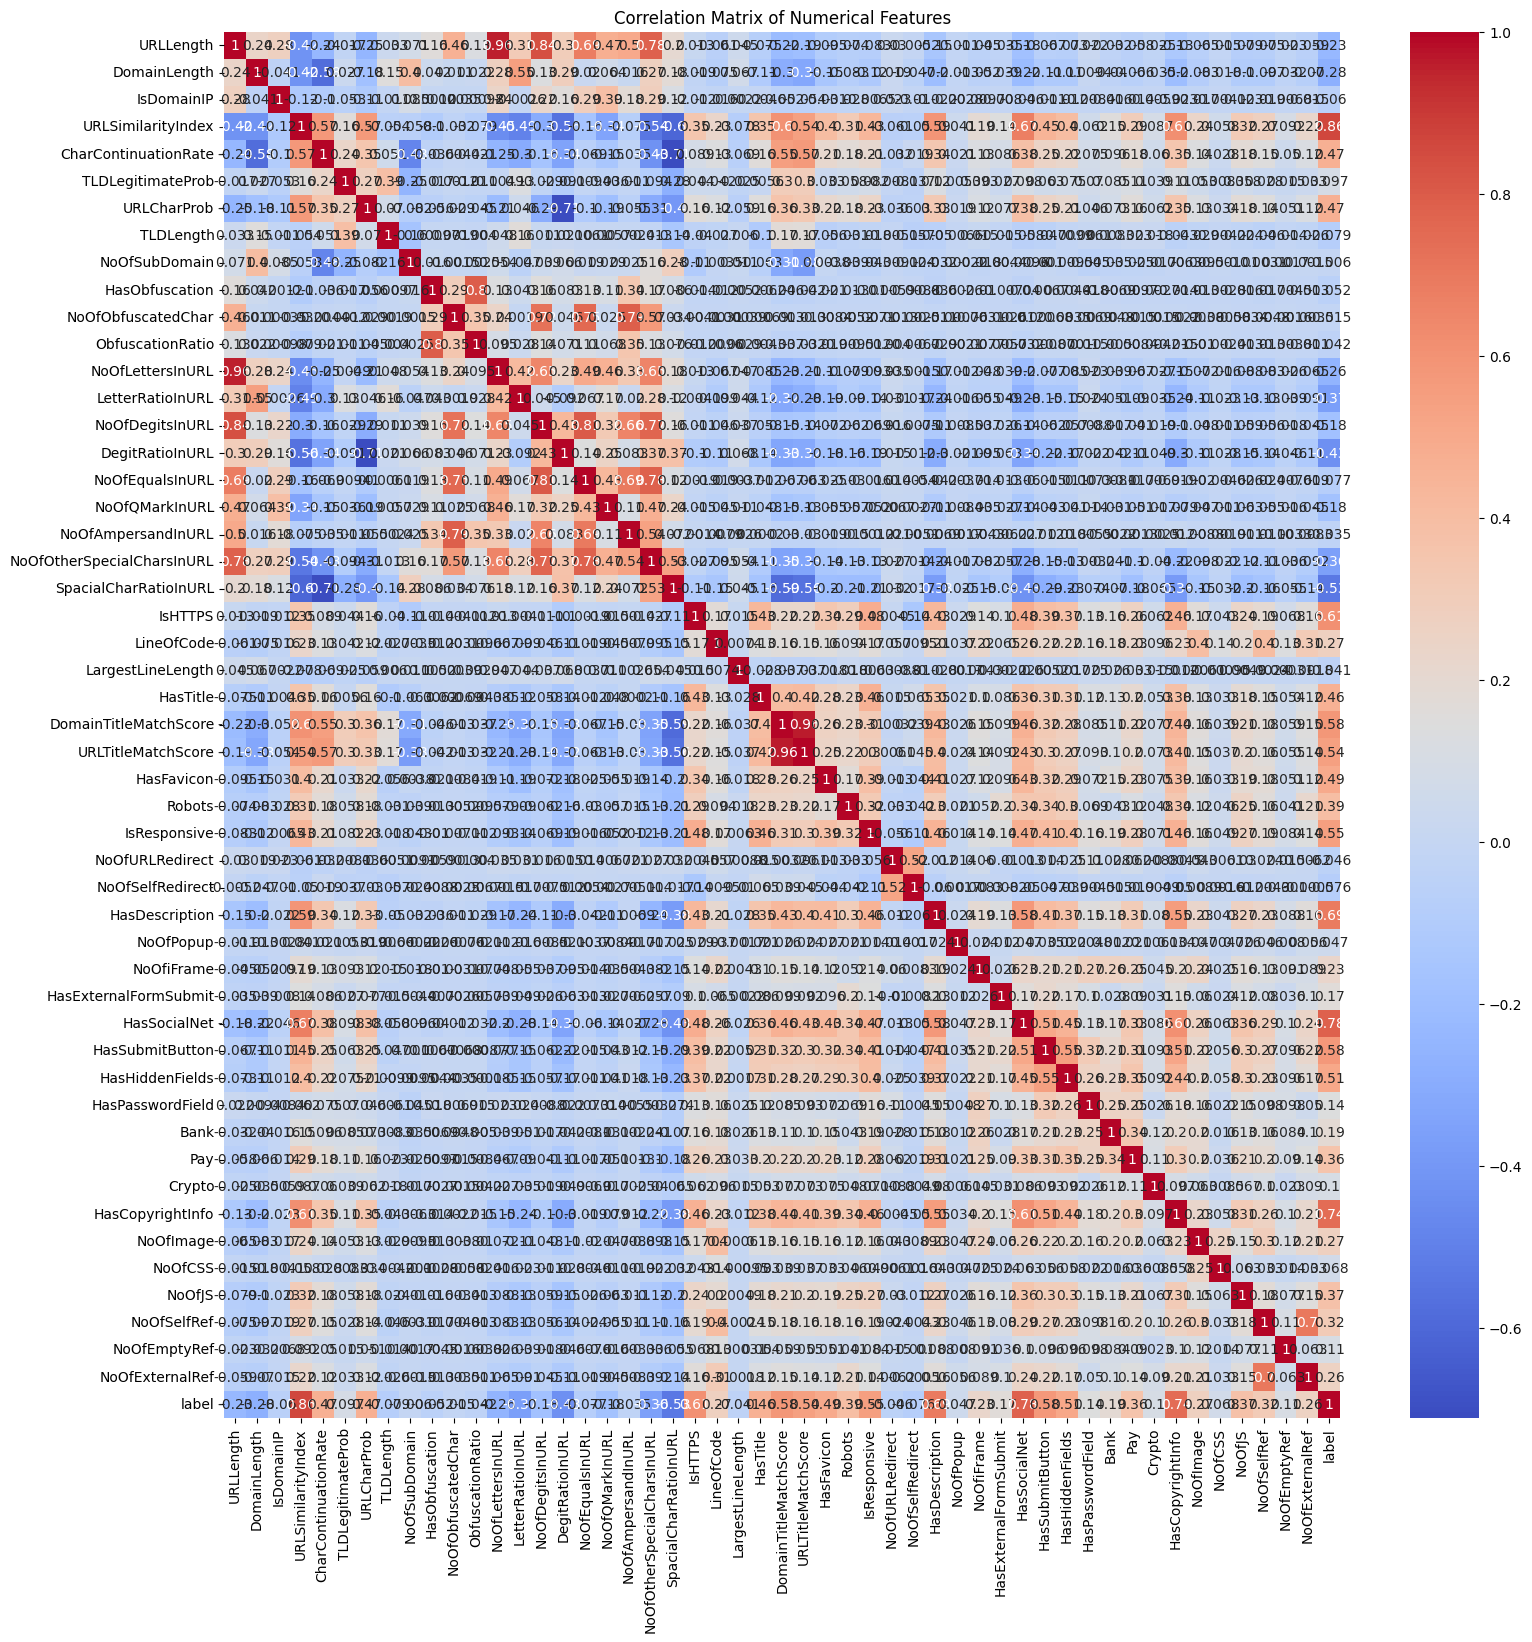

In [15]:
# Visualize correlation matrix for numerical features
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

-->It is too complicated so first we do feature imporatance then we visualize

In [16]:
# Feature selection using RandomForestClassifier
X = numeric_df.drop('label', axis=1, errors='ignore')
y = numeric_df['label']

model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [17]:
# Feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [18]:
print("\nFeature Importance:")
display(importance_df)


Feature Importance:


,Feature,Importance
3,URLSimilarityIndex,2.232299e-01
22,LineOfCode,1.646706e-01
49,NoOfExternalRef,1.373823e-01
47,NoOfSelfRef,1.251217e-01
44,NoOfImage,8.402900e-02
45,NoOfCSS,3.934248e-02
36,HasSocialNet,3.443758e-02
46,NoOfJS,2.918669e-02
23,LargestLineLength,2.866890e-02
32,HasDescription,2.348410e-02


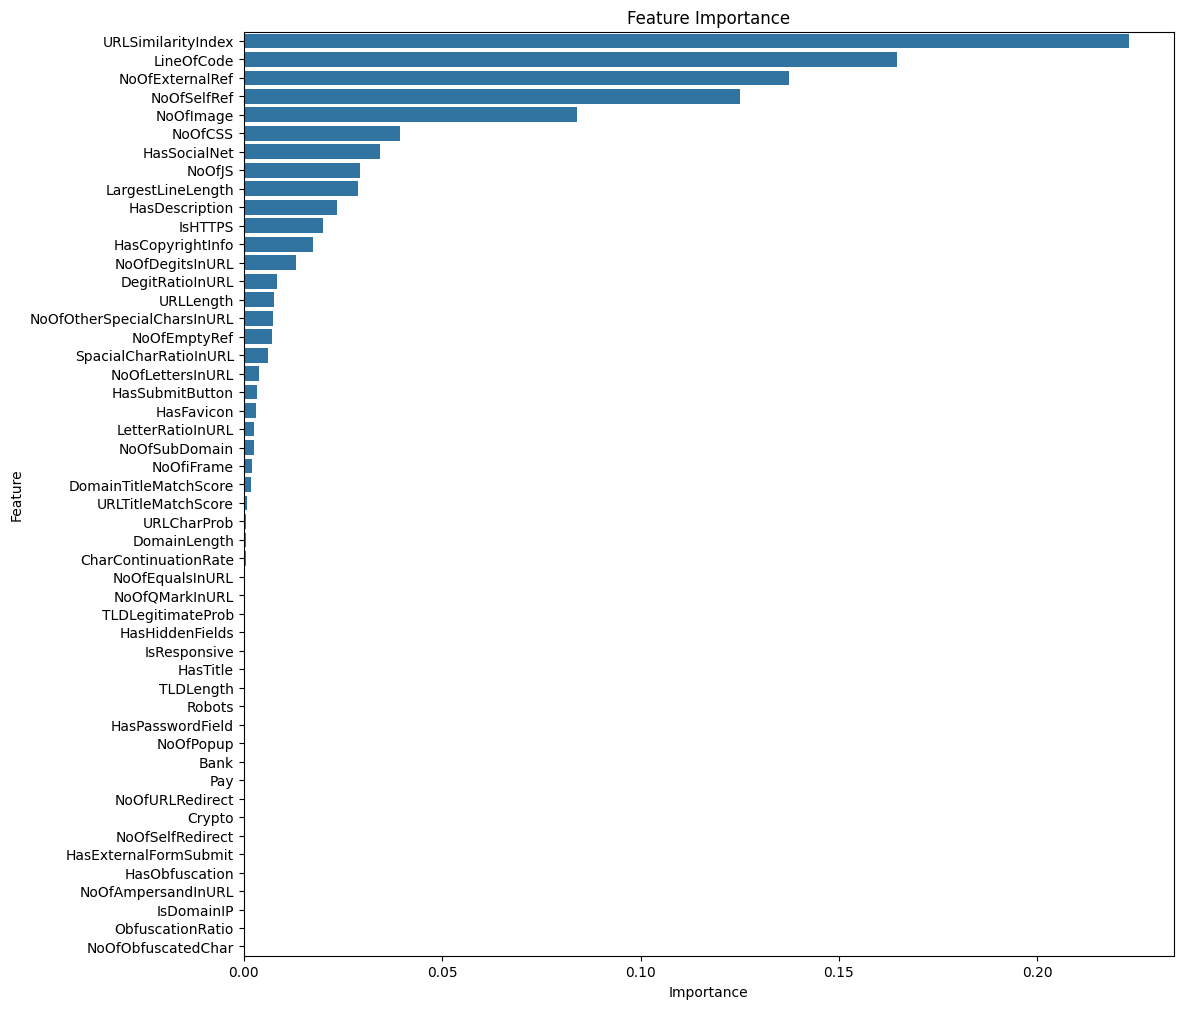

In [19]:
# Visualize feature importance
plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

After visualizing the bar graph of feature importance, it's clear that some features, such as HasPasswordField, HasHiddenFields, Pay, Bank, and URLTitleMatchScore, cannot be directly extracted from the URL. These require crawling or analyzing website content, which may violate legal or ethical guidelines. Features like URLLength and DomainLength are safe to extract directly from the URL without issues.

##*
#So we have to make our own custom data

In [20]:
df = pd.DataFrame(df,columns=['URL','label'])

In [21]:
# Display initial data overview
print("Dataset Head:")
display(df.head())


Dataset Head:


,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [22]:
df.to_csv("url.csv", index=False)

In [23]:
# Load dataset
df = pd.read_csv('/content/url.csv')
df = df.iloc[-10000:]

In [24]:
print(df.shape)

(10000, 2)


In [25]:
print(df.head())

                                                      URL  label
225810             http://www.sbi.mx/page/41/786/code.php      0
225811                          http://www.exeimplant.com      0
225812  http://chmsgroup-access.cf/secure/document/aut...      0
225813                          https://www.myhrescoey.se      1
225814                       http://www.nudesalon.digital      0


In [26]:
print(df.tail())

                                 URL  label
235805         https://www.amzon.com      0
235806  http://www.twItter.com/login      0
235807      https://www.facedook.com      0
235808     https://www.wikipedia.org      1
235809        https://www.youtub.com      0


In [27]:
# Define the URL Feature Extractor
class URLFeatureExtractor:
    def __init__(self):
        self.suspicious_keywords = [
            'login', 'verify', 'update', 'account', 'secure', 'banking',
            'signin', 'confirm', 'password', 'credential', 'security'
        ]
        self.suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz']

    def extract_features(self, url):
        """Extract features from a single URL"""
        features = {}
        parsed_url = urlparse(url.lower())
        features['url_length'] = len(url)
        features['domain_length'] = len(parsed_url.netloc)
        features['path_length'] = len(parsed_url.path)
        features['is_https'] = 1 if parsed_url.scheme == 'https' else 0
        features['special_char_count'] = sum(url.count(c) for c in "@#$%^&*()+=[]{}|;:,.<>?")
        features['is_ip_address'] = self._is_ip_address(parsed_url.netloc)
        features['suspicious_keyword_count'] = self._count_suspicious_keywords(url)
        features['has_suspicious_tld'] = self._check_suspicious_tld(parsed_url.netloc)
        features['directory_depth'] = parsed_url.path.count('/')
        features['query_param_count'] = len(parse_qs(parsed_url.query))
        features['fragment_length'] = len(parsed_url.fragment)
        features['has_subdomain'] = 1 if parsed_url.netloc.count('.') > 1 else 0
        features['domain_has_numbers'] = 1 if any(char.isdigit() for char in parsed_url.netloc) else 0
        features['query_param_length'] = sum(len(val) for val in parse_qs(parsed_url.query).values())
        features['subdomain_count'] = parsed_url.netloc.count('.') - 1
        features['uses_ip_in_url'] = 1 if parsed_url.netloc.replace('.', '').isdigit() else 0
        features['long_path'] = 1 if len(parsed_url.path) > 50 else 0
        features['has_hyphens_in_domain'] = 1 if '-' in parsed_url.netloc else 0
        features['has_at_symbol'] = 1 if '@' in url else 0
        features['has_misspelled_domain'] = self._has_misspelled_domain(parsed_url.netloc)
        features['is_shortened_url'] = self._is_shortened_url(url)
        features['domain_name'], features['tld'] = self._extract_domain_tld(url)
        return features

    def _is_ip_address(self, domain):
        try:
            ipaddress.ip_address(domain.split(':')[0])
            return 1
        except ValueError:
            return 0

    def _count_suspicious_keywords(self, url):
        return sum(1 for keyword in self.suspicious_keywords if keyword in url)

    def _check_suspicious_tld(self, domain):
        return int(any(domain.endswith(tld) for tld in self.suspicious_tlds))

    def _has_misspelled_domain(self, domain):
        misspelled_patterns = [
            r"0{1,}o", r"1{1,}l", r"3{1,}e", r"1{1,}i", r"(.)\1{2,}",
            r"faecbook", r"gogle", r"(o{2,}|g{2,}|e{2,})", r"ht{1,}:\/\/",
            r"g{2,}le", r"fa{2,}cebook", r"0o{1,}gle", r"t{1,}witter"
        ]
        return int(any(re.search(pattern, domain) for pattern in misspelled_patterns))

    def _is_shortened_url(self, url):
        shortened_domains = [
            'bit.ly', 'tinyurl.com', 'goo.gl', 't.co', 'ow.ly', 'is.gd', 'buff.ly', 'adf.ly'
        ]
        domain = urlparse(url).netloc
        return int(domain in shortened_domains)

    def _extract_domain_tld(self, url):
        extracted = tldextract.extract(url)
        return extracted.domain, extracted.suffix


In [28]:
def add_features_to_dataframe(df):
    extractor = URLFeatureExtractor()
    features = df['URL'].apply(extractor.extract_features)
    features_df = pd.DataFrame(features.tolist())
    df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
    return df

In [29]:
df = add_features_to_dataframe(df)
df.to_csv('url_features.csv', index=False)

In [30]:
# Handle missing values
df = pd.read_csv('/content/url_features.csv')
df.dropna(inplace=True)

In [31]:
# Encode TLDs
le = LabelEncoder()
df['tld_encoded'] = le.fit_transform(df['tld'])

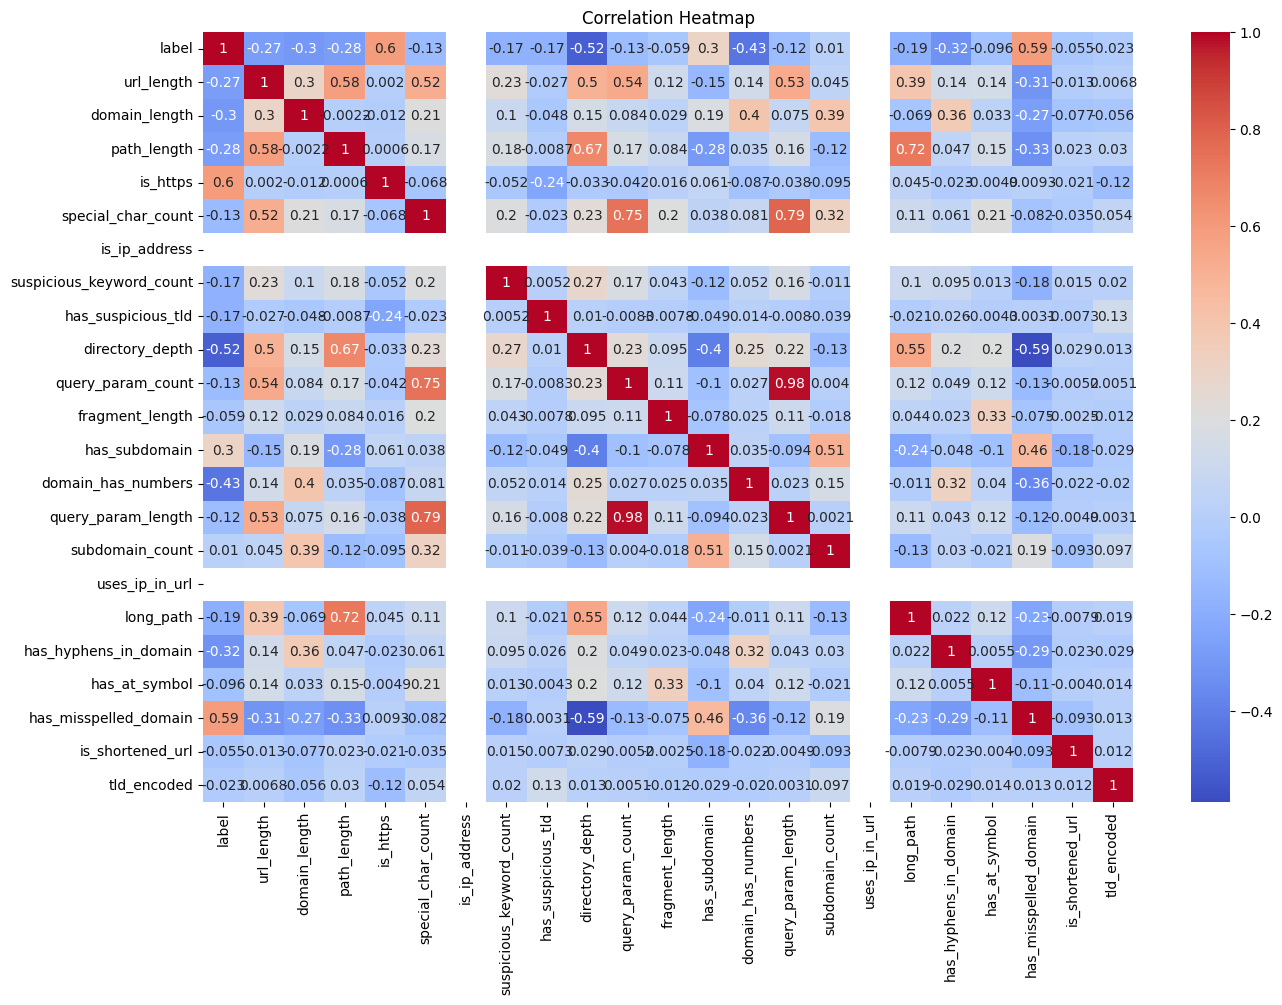

In [32]:
# Correlation heatmap
numerical_features = df.select_dtypes(include=['number'])
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##Conclusion
-->we have to drop column uses_ip_in_url,is_ip_address because they have a value 0 for both phishing and safe.

-->is_https,has_misspelled_domain,has_subdomain columns are highly correlated with the label

In [33]:
# Drop redundant columns
df.drop(['uses_ip_in_url', 'is_ip_address'], axis=1, inplace=True)


In [34]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [35]:
# Tokenize domain names
def tokenize_domain(domain):
    return list(domain.lower())

df['tokens'] = df['domain_name'].apply(tokenize_domain)

# Train Word2Vec model
tokenized_domains = df['tokens'].tolist()
word2vec_model = Word2Vec(
    sentences=tokenized_domains,
    vector_size=100, window=5, min_count=1, sg=1, workers=4, epochs=10
)

# Generate embeddings
def get_domain_embedding(tokens, model):
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if len(embeddings) > 0:
        return sum(embeddings) / len(embeddings)
    return [0] * model.vector_size

df['domain_embedding'] = df['tokens'].apply(lambda x: get_domain_embedding(x, word2vec_model))
embeddings_df = pd.DataFrame(df['domain_embedding'].tolist(), columns=[f"embedding_{i}" for i in range(100)])
features_df = pd.concat([df.drop(['URL', 'domain_name', 'tld', 'domain_embedding', 'tokens'], axis=1), embeddings_df], axis=1)

In [36]:
features_df.isnull().sum()

,0
label,23
url_length,23
domain_length,23
path_length,23
is_https,23
...,...
embedding_95,23
embedding_96,23
embedding_97,23
embedding_98,23


In [37]:
features_df.dropna(inplace=True)

In [38]:
features_df.isnull().sum()

,0
label,0
url_length,0
domain_length,0
path_length,0
is_https,0
...,...
embedding_95,0
embedding_96,0
embedding_97,0
embedding_98,0


In [39]:
# Prepare data for training
X = features_df.drop('label', axis=1)
y = features_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Stacking classifier
base_models = [
    ('rf', RandomForestClassifier(
                n_estimators=183,
                max_depth=21,
                min_samples_split=7,
                min_samples_leaf=4,
                max_features='sqrt',
                random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(random_state=42), cv=3)
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=21,
                                                       min_samples_leaf=4,
                                                       min_samples_split=7,
                                                       n_estimators=183,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(n_estimators=50,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [41]:
# Evaluate model
y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.2f}")


Stacking Model Accuracy: 1.00


In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

Confusion Matrix: [[ 833    3]
 [   0 1155]]


In [43]:
# !pip install optuna

In [44]:
# import optuna
# # Assuming features_df is already defined with your data
# X = features_df.drop('label', axis=1)
# y = features_df['label']  # Target variable

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Define the objective function for Optuna
# def objective(trial):
#     # Hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)
#     max_depth = trial.suggest_int('max_depth', 5, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])


#     max_samples = trial.suggest_float('max_samples', 0.5, 1.0)  # Subset of data for each tree


#     # Initialize the Random Forest model with the selected hyperparameters
#     model = RandomForestClassifier(n_estimators=n_estimators,
#                                    max_depth=max_depth,
#                                    min_samples_split=min_samples_split,
#                                    min_samples_leaf=min_samples_leaf,
#                                    max_features=max_features,
#                                    max_samples=max_samples,
#                                    random_state=42)

#     # Train the model
#     model.fit(X_train, y_train)

#     # Make predictions and compute accuracy
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

# # Create an Optuna study object for optimization
# study = optuna.create_study(direction='maximize')  # Maximize accuracy
# study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

# # Output the best hyperparameters and the corresponding accuracy
# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best accuracy: {study.best_value}")

With the help of optuna i find the hyperparameter for RandomForestClassifier(
                n_estimators=183,
                max_depth=21,
                min_samples_split=7,
                min_samples_leaf=4,
                max_features='sqrt',
                random_state=42)

In [45]:
def predict_specific_url(url, word2vec_model, trained_model, label_encoder, feature_names):
    """
    Predict whether a given URL is phishing or safe.

    Args:
        url (str): The URL to analyze.
        word2vec_model: Pretrained Word2Vec model for domain embeddings.
        trained_model: Trained classification model (e.g., StackingClassifier).
        label_encoder: Label encoder for the TLD (top-level domain).
        feature_names: List of feature names (must match training).

    Returns:
        str: Prediction result ("Phishing" or "Safe").
        float: Confidence score for phishing.
    """
    extractor = URLFeatureExtractor()

    # Step 1: Extract features from the URL
    features = extractor.extract_features(url)

    # Encode the TLD
    try:
        tld_encoded = label_encoder.transform([features['tld']])[0]
    except ValueError:
        tld_encoded = -1  # Default encoding for unseen TLDs
    features['tld_encoded'] = tld_encoded

    # Step 2: Generate domain embedding
    domain_name = features['domain_name']
    tokens = list(domain_name.lower())  # Tokenize the domain
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]

    # Average embedding for the domain
    if len(embeddings) > 0:
        domain_embedding = sum(embeddings) / len(embeddings)
    else:
        domain_embedding = [0] * word2vec_model.vector_size  # Default vector

    # Step 3: Combine extracted features and embeddings into a feature vector
    feature_vector = [
        features['url_length'],
        features['domain_length'],
        features['path_length'],
        features['is_https'],
        features['special_char_count'],
        features['suspicious_keyword_count'],
        features['has_suspicious_tld'],
        features['directory_depth'],
        features['query_param_count'],
        features['fragment_length'],
        features['has_subdomain'],
        features['domain_has_numbers'],
        features['query_param_length'],
        features['subdomain_count'],
        features['long_path'],
        features['has_hyphens_in_domain'],
        features['has_at_symbol'],
        features['has_misspelled_domain'],
        features['is_shortened_url'],
        features['tld_encoded']
    ]

    # Append the domain embedding to the feature vector
    feature_vector.extend(domain_embedding)

    # Convert the feature vector into a DataFrame
    feature_df = pd.DataFrame([feature_vector], columns=feature_names)

    # Step 4: Make a prediction using the trained model
    prediction = trained_model.predict(feature_df)[0]
    prediction_proba = trained_model.predict_proba(feature_df)[0]

    # Step 5: Interpret results
    result = "Safe" if prediction == 1 else "Phishing"
    confidence = prediction_proba[0] if prediction == 0 else prediction_proba[1]
    return result, confidence


In [47]:
feature_names = features_df.drop('label', axis=1).columns.tolist()

In [48]:
# Example URL
example_url = "http://suspicious-login.tk/verify"

# Predict
result, confidence = predict_specific_url(
    url=example_url,
    word2vec_model=word2vec_model,
    trained_model=stacking_model,
    label_encoder=le,
    feature_names=feature_names
)

# Print the results
print(f"Prediction for URL '{example_url}': {result}")
print(f"Confidence Score: {confidence:.2f}")


Prediction for URL 'http://suspicious-login.tk/verify': Phishing
Confidence Score: 1.00
